# VGG-16
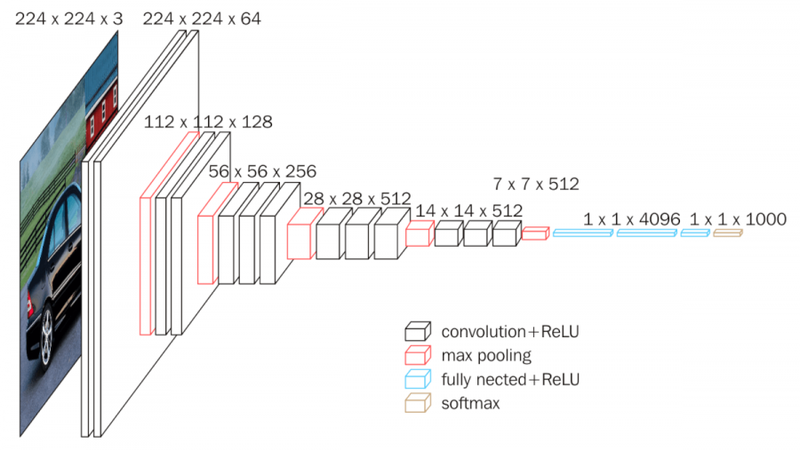

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.applications import imagenet_utils

In [2]:
cifar100 = keras.datasets.cifar100

In [3]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_test = X_train/255.0, X_test /255.0

print('X_train : ', len(X_train), 'X_test : ', len(X_test))

169009152/169001437 [==============================] - 2s 0us/step
X_train :  50000 X_test :  10000


### 기존 분류기

In [5]:
img_input = keras.Input(shape=(32,32,3))

x = keras.layers.Conv2D(16, 3, activation='relu')(img_input)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
predictions = keras.layers.Dense(100, activation='softmax')(x)

model = keras.Model(inputs=img_input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               295168

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1)

1563/1563 [==============================] - 11s 5ms/step - loss: 4.0241 - accuracy: 0.0947


### VGG16 으로 바꿔보자
   
   
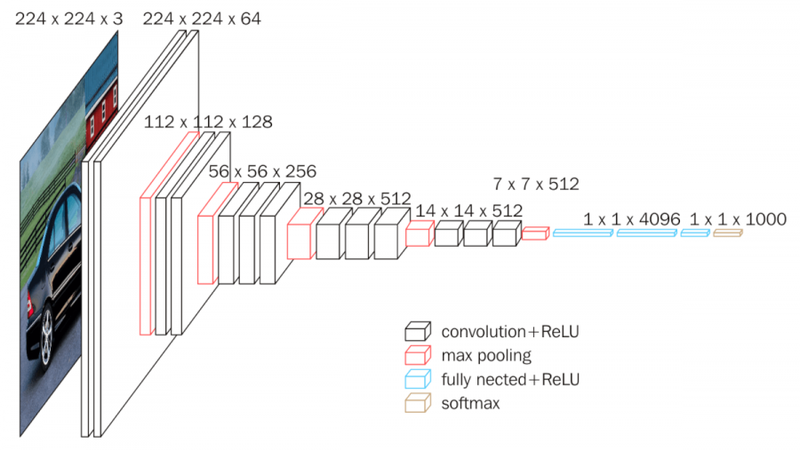

In [15]:
# 첫번째 블록
x = layers.Conv2D(64,(3,3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = layers.Conv2D(64,(3,3), activation='relu', padding='same', name='block1_conv2')(x)
x = layers.MaxPooling2D((2,2), strides=(2,2), name='block1_pool')(x)

In [16]:
# 두번째 블록
x = layers.Conv2D(128,(3,3), activation='relu', padding='same', name='block2_conv1')(x)
x = layers.Conv2D(128,(3,3), activation='relu', padding='same', name='block2_conv2')(x)
x = layers.MaxPooling2D((2,2), strides=(2,2), name='block2_pool')(x)

In [17]:
# 세번째 블록
x = layers.Conv2D(256,(3,3), activation='relu', padding='same', name='block3_conv1')(x)
x = layers.Conv2D(256,(3,3), activation='relu', padding='same', name='block3_conv2')(x)
x = layers.Conv2D(256,(3,3), activation='relu', padding='same', name='block3_conv3')(x)
x = layers.MaxPooling2D((2,2), strides=(2,2), name='block3_pool')(x)

In [18]:
# 네번째 블록
x = layers.Conv2D(512,(3,3), activation='relu', padding='same', name='block4_conv1')(x)
x = layers.Conv2D(512,(3,3), activation='relu', padding='same', name='block4_conv2')(x)
x = layers.Conv2D(512,(3,3), activation='relu', padding='same', name='block4_conv3')(x)
x = layers.MaxPooling2D((2,2), strides=(2,2), name='block4_pool')(x)

In [19]:
# 다섯번째 블록
x = layers.Conv2D(512,(3,3), activation='relu', padding='same', name='block5_conv1')(x)
x = layers.Conv2D(512,(3,3), activation='relu', padding='same', name='block5_conv2')(x)
x = layers.Conv2D(512,(3,3), activation='relu', padding='same', name='block5_conv3')(x)
x = layers.MaxPooling2D((2,2), strides=(2,2), name='block5_pool')(x)

In [20]:
# 여섯번째 블록
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(100, activation='softmax', name='predictions')(x)

In [21]:
model = keras.Model(name="VGG-16", inputs=img_input, outputs=x)

model.summary()

Model: "VGG-16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0    

In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1)

1563/1563 [==============================] - 135s 75ms/step - loss: 4.6063 - accuracy: 0.0101


# ResNet-50

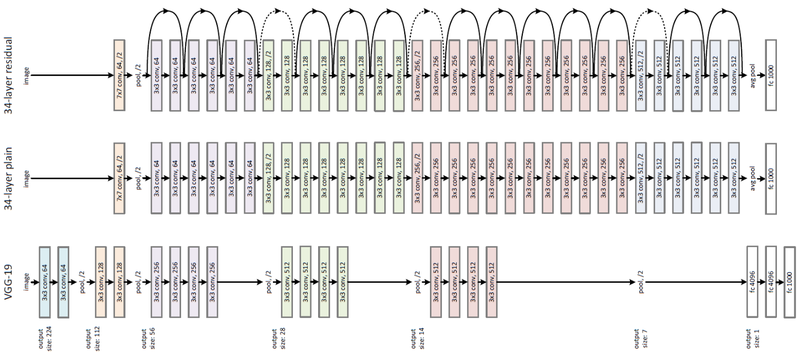

In [24]:
from tensorflow.python.keras import backend
from tensorflow.python.keras import regularizers
from tensorflow.python.keras import initializers
from tensorflow.python.keras import models

In [25]:
# block 안에 반복적으로 활용되는 L2 regularizer 선언
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
    return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

In [26]:
def conv_block(input_tensor,
              kernel_size,
              filters,
              stage,
              block,
              strides=(2,2),
              use_l2_regularizer=True,
              batch_norm_decay=0.9,
              batch_norm_epsilon=1e-5):
    
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1,
                      (1, 1),
                      use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon,
                                  name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2,
                      kernel_size,
                      strides=strides,
                      padding='same',
                      use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                      name=conv_name_base + '2b')(x)
    
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon,
                                  name=bn_name_base + '2b')(x)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                      name=conv_name_base + '2c')(x)
    
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon,
                                  name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1),
                             strides=strides,
                             use_bias=False,
                             kernel_initializer='he_normal',
                             kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                             name=conv_name_base + '1')(input_tensor)

    shortcut = layers.BatchNormalization(axis=bn_axis,
                                         momentum=batch_norm_decay,
                                         epsilon=batch_norm_epsilon,
                                         name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [27]:
def identity_block(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5):
 
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                      name=conv_name_base + '2a')(input_tensor)
  
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon,
                                  name=bn_name_base + '2a')(x)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2,
                      kernel_size,
                      padding='same',
                      use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                      name=conv_name_base + '2b')(x)
    
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon,
                                  name=bn_name_base + '2b')(x)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                      name=conv_name_base + '2c')(x)
    
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon,
                                  name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [29]:
def resnet50(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):

    input_shape = (32, 32, 3) 
    img_input = layers.Input(shape=input_shape, batch_size=batch_size)
    if rescale_inputs:
    # Hub image modules expect inputs in the range [0, 1]. This rescales these
    # inputs to the range expected by the trained model.
        x = layers.Lambda(
        lambda x: x * 255.0 - backend.constant(imagenet_preprocessing.CHANNEL_MEANS,
                                               shape=[1, 1, 3],
                                               dtype=x.dtype),name='rescale')(img_input)
    else:
        x = img_input

    if backend.image_data_format() == 'channels_first':
        x = layers.Permute((3, 1, 2))(x)
        bn_axis = 1
    else:  # channels_last
        bn_axis = 3

    block_config = dict(
        use_l2_regularizer=use_l2_regularizer,
        batch_norm_decay=batch_norm_decay,
        batch_norm_epsilon=batch_norm_epsilon)
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon,
                                  name='bn_conv1')(x)
    
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), **block_config)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', **block_config)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', **block_config)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', **block_config)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', **block_config)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', **block_config)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', **block_config)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', **block_config)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', **block_config)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', **block_config)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', **block_config)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', **block_config)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', **block_config)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', **block_config)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', **block_config)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', **block_config)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes,
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                     bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                     name='fc1000')(x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
    x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
    return models.Model(img_input, x, name='resnet50')

In [30]:
model = resnet50(num_classes=100)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1)  

1563/1563 [==============================] - 364s 201ms/step - loss: 9.2647 - accuracy: 0.0516
